In [1]:
import torch.utils
import torchvision
from torch import nn
import numpy as np
import os
import json
import pickle
import torch
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms,datasets
import torchvision.models as models
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

rootPath = "../../data/csdn/39bird/"
epochs = 10
lr = 0.03
batch_size = 32
image_path = rootPath+'data'
save_path = rootPath+ 'checkpoint/best_model.pkl'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 数据转换
mean = [0.485,0.456,0.406]
std = [0.229,0.224,0.225]
data_transform = {
     'train':transforms.Compose([
         transforms.RandomResizedCrop(224), # 随机裁剪
         transforms.RandomHorizontalFlip(), # 左右翻转
         transforms.ToTensor(),
         transforms.Normalize(mean,std) # 均值方差归一化
     ])
}

# 构造训练集
train_dataset = datasets.ImageFolder(root=os.path.join(image_path),transform=data_transform['train'])
# 构造迭代器
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size,True)

print('using {} images for training.'.format(len(train_dataset)))

# 建立分类标签和索引的关系
cloth_list = train_dataset.class_to_idx
class_dict = {}
for keyName,index in cloth_list.items():
    class_dict[index] = keyName
with open(rootPath+'class_dist.pk','wb') as f:
    pickle.dump(class_dict,f)

# 自定义损失函数，主要在forward中定义过程
class MyLoss(nn.Module):
    def __init__(self):
        super(MyLoss,self).__init__()

    # 参数位预测值和真实值，返回所有样本的损失值，反向传播pytorch会自动执行计算过程，
    def forward(self,pred,label):  
        exp = torch.exp(pred)
        tmp1 = exp.gather(1,label.unsqueeze(-1)).squeeze()
        tmp2 = exp.sum(1)
        softmax = tmp1/tmp2
        log = -torch.log(softmax)
        return log.mean()

# 加载googlenet模型, 预训练好的模型
model = torchvision.models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)

# 冻结模型参数，不参与梯度计算
for param in model.parameters():
    param.requires_grad = False

# 修改最后一层全连接层
# fc 是模型中的全连接层（通常在卷积神经网络的末尾，用于分类任务）
# 在迁移学习中使用，当你需要将一个预训练的模型应用于一个不同类别数量的任务时。
# 例如，如果原始模型是为 1000 类的 ImageNet 数据集训练的，但你的任务只有 4 个类别，你就需要将输出层的维度从 1000 改为 4。
model.fc = nn.Linear(model.fc.in_features,4)

# 将模型加载到设备中
model =  model.to(device)
# 定义损失函数
criterion = MyLoss()
# 定义优化器
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

# 模型训练
best_acc = 0
best_model = None

for epoch in range(epochs):
    model.train()
    # 损失
    running_loss = 0
    # 每个epoch准确率
    epoch_acc = 0
    # 每个epoch训练的样本数
    epoch_acc_count = 0
     # 用于计算总的样本数，方便求准确率
    train_count = 0
    # 进度条
    train_bar = tqdm(train_loader)

    for data in train_bar:
        images,labels = data
        # 清空梯度
        optimizer.zero_grad()
        # 模型执行
        output = model(images.to(device))
        # 计算损失
        loss = criterion(output,labels.to(device))
        # 反向传播
        loss.backward()
        # 更新模型的参数，使其朝着减少损失的方向移动
        optimizer.step()

        running_loss +=loss.item()
        train_bar.desc = "train epoc [{}/{}] loss:{:.3f}".format(epoch+1, epochs, loss)

        # 计算每个epoch正确的个数,预测的结果和实际的结果是否相等
        epoch_acc_count += (output.argmax(axis=1)==labels.to(device).view(-1)).sum()
        train_count += len(images)
    
    # 每个epoch对应的准确率
    epoch_acc = epoch_acc_count/train_count

    print("[EPOCH:]%s" %str(epoch+1))
    print("训练损失为%s" %str(running_loss))
    print("训练精度为%s" %(str(epoch_acc.item()*100)[:5]) + '%')

    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = model.state_dict
    
    # 在训练结束保持最优的模型参数
    if epoch == epochs - 1:
        torch.save(best_model,save_path)
    
print("Finished Training")

using 149 images for training.


train epoc [1/10] loss:2.177:  40%|████      | 2/5 [00:03<00:05,  1.69s/it]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


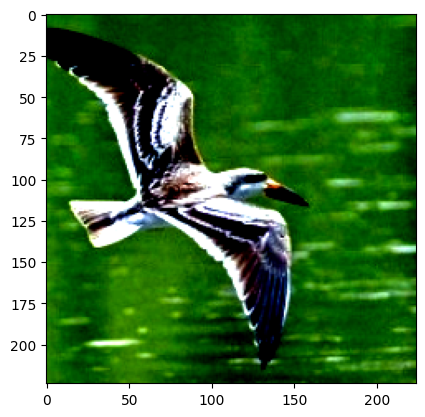

class_dict {0: 'Bananaquit', 1: 'Black Skimmer', 2: 'Black Throated Bushtiti', 3: 'Cockatoo'}
[预测结果分类]: Bananaquit


In [16]:
# 模型使用
# 加载索引雨标签映射字典
class_dict = {}
with open(rootPath+'class_dist.pk','rb') as f:
    class_dict = pickle.load(f)

# 数据转换
data_transform2 = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,std=std)
    ]
)

# 图片路径
test_image_path = rootPath + 'data/Black Skimmer/003.jpg'
# 打开图片
img = Image.open(test_image_path)
# 对图像转换
img = data_transform2(img)
plt.imshow(img.permute(1,2,0))
plt.show()

# 将图像升维，增加batch_size维度
img = torch.unsqueeze(img,dim=0)
img = img.to(device)
# 获取预测结果
print('class_dict',class_dict)
pred = class_dict[model(img).argmax(axis=1).item()]
print('[预测结果分类]: %s' %pred)




